In [13]:
### Feature Extractor ###

# Import the functions to calculate feature descriptors
from skimage.feature import hog
from skimage.io import imread
import joblib
from skimage.transform import resize
import cv2
# To read file names
import glob
import os

import matplotlib.pyplot as plt

def convert_to_gray(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

if __name__ == "__main__":
    
    orientations = 9
    pixels_per_cell = (8, 8)
    cells_per_block = (2, 2)
    pos_im_path = "dataset/train/positives"
    neg_im_path = "dataset/train/negatives"
    pos_feat_ph = ("output/positives_features")
    neg_feat_ph = ("output/negatives_features")
        
    #"Calculating the descriptors for the positive samples and saving them"
    for im_path in glob.glob(os.path.join(pos_im_path, "*")):
        im = imread(im_path)
        im = convert_to_gray(im)
        im_resized = resize(im, (64,64))
        fd = hog(im_resized, orientations, pixels_per_cell, cells_per_block)
        fd_name = os.path.split(im_path)[1].split(".")[0] + ".feat"
        fd_path = os.path.join(pos_feat_ph, fd_name)
        joblib.dump(fd, fd_path)
    print ("Positive features saved in {}".format(pos_feat_ph))

    #"Calculating the descriptors for the negative samples and saving them"
    for im_path in glob.glob(os.path.join(neg_im_path, "*")):
        im = imread(im_path)
        im = convert_to_gray(im)
        im_resized = resize(im, (64,64))
        fd = hog(im_resized, orientations, pixels_per_cell, cells_per_block)
        fd_name = os.path.split(im_path)[1].split(".")[0] + ".feat"
        fd_path = os.path.join(neg_feat_ph, fd_name)
        joblib.dump(fd, fd_path)
    print("Negative features saved in {}".format(neg_feat_ph))

Positive features saved in output/positives_features
Negative features saved in output/negatives_features


In [14]:
### Training the classifier (SVM) ###

# Import the functions to calculate feature descriptors
from skimage.feature import hog
from sklearn.svm import LinearSVC
import joblib
import cv2
# To read file names
import glob
import os

if __name__ == "__main__":

    model_path = "output/models"
    pos_feat_path = "output/positives_features"
    neg_feat_path = "output/negatives_features"

    fds = []
    labels = []
    
    # Load the positive features
    for feat_path in glob.glob(os.path.join(pos_feat_path,"*.feat")):
        fd = joblib.load(feat_path)
        fds.append(fd)
        labels.append(1)

    # Load the negative features
    for feat_path in glob.glob(os.path.join(neg_feat_path,"*.feat")):
        fd = joblib.load(feat_path)
        fds.append(fd)
        labels.append(0)

    #"Training a Linear SVM Classifier"
    clf = LinearSVC()
    clf.fit(fds, labels)
    
    model_path = os.path.join("output/models", 'model.pkl')
    joblib.dump(clf, model_path)    
        # Print information about the model
    print("Number of features:", clf.coef_.shape[1])
    print("Coefficients shape:", clf.coef_.shape)
    print("Intercept shape:", clf.intercept_.shape)

    
    print ("Classifier saved")

Number of features: 1764
Coefficients shape: (1, 1764)
Intercept shape: (1,)
Classifier saved


D:\Programs\Anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Width: 416, Height: 416, Channels: 3
Window Size: (64, 64)
Detection:: Location -> (250, 260)
Scale ->  0 | Confidence Score [0.83742737] 

Window Size: (64, 64)
Detection:: Location -> (260, 260)
Scale ->  0 | Confidence Score [0.97211429] 

Window Size: (64, 64)
Detection:: Location -> (270, 260)
Scale ->  0 | Confidence Score [0.80855186] 

Window Size: (64, 64)
Detection:: Location -> (260, 290)
Scale ->  0 | Confidence Score [0.70311939] 

Window Size: (64, 64)
Detection:: Location -> (260, 300)
Scale ->  0 | Confidence Score [0.78462339] 

Window Size: (64, 64)
Detection:: Location -> (200, 110)
Scale ->  1 | Confidence Score [0.7214848] 

Window Size: (64, 64)
Detection:: Location -> (200, 130)
Scale ->  1 | Confidence Score [0.72670513] 

Window Size: (64, 64)
Detection:: Location -> (170, 140)
Scale ->  1 | Confidence Score [0.71217063] 

Window Size: (64, 64)
Detection:: Location -> (210, 170)
Scale ->  1 | Confidence Score [0.85118857] 

Window Size: (64, 64)
Detection:: Loc

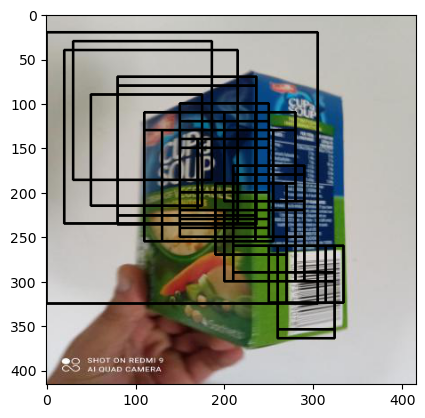

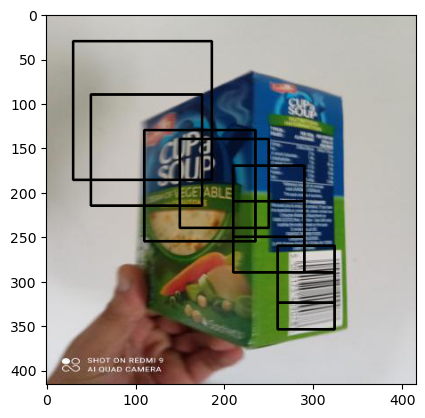

In [32]:
### Testing the classifier (SVM) ###

# Import the required modules
from skimage.transform import pyramid_gaussian
from skimage.io import imread
from skimage.feature import hog
import joblib
import cv2
import numpy as np
import matplotlib.pyplot as plt


def sliding_window(image, window_size, step_size):
    for y in range(0, image.shape[0], step_size):
        for x in range(0, image.shape[1], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def convert_to_gray(img):
    img = cv2.convertScaleAbs(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

def overlapping_area(detection_1, detection_2):
    '''
    Function to calculate overlapping area'si
    `detection_1` and `detection_2` are 2 detections whose area
    of overlap needs to be found out.
    Each detection is list in the format ->
    [x-top-left, y-top-left, confidence-of-detections, width-of-detection, height-of-detection]
    The function returns a value between 0 and 1,
    which represents the area of overlap.
    0 is no overlap and 1 is complete overlap.
    Area calculated from ->
    http://math.stackexchange.com/questions/99565/simplest-way-to-calculate-the-intersect-area-of-two-rectangles
    '''
    # Calculate the x-y co-ordinates of the 
    # rectangles
    x1_tl = detection_1[0]
    x2_tl = detection_2[0]
    x1_br = detection_1[0] + detection_1[3]
    x2_br = detection_2[0] + detection_2[3]
    y1_tl = detection_1[1]
    y2_tl = detection_2[1]
    y1_br = detection_1[1] + detection_1[4]
    y2_br = detection_2[1] + detection_2[4]
    # Calculate the overlapping Area
    x_overlap = max(0, min(x1_br, x2_br)-max(x1_tl, x2_tl))
    y_overlap = max(0, min(y1_br, y2_br)-max(y1_tl, y2_tl))
    overlap_area = x_overlap * y_overlap
    area_1 = detection_1[3] * detection_2[4]
    area_2 = detection_2[3] * detection_2[4]
    total_area = area_1 + area_2 - overlap_area
    return overlap_area / float(total_area)

def nms(detections, threshold=.5):
    '''
    This function performs Non-Maxima Suppression.
    `detections` consists of a list of detections.
    Each detection is in the format ->
    [x-top-left, y-top-left, confidence-of-detections, width-of-detection, height-of-detection]
    If the area of overlap is greater than the `threshold`,
    the area with the lower confidence score is removed.
    The output is a list of detections.
    '''
    if len(detections) == 0:
        return []
    # Sort the detections based on confidence score
    detections = sorted(detections, key=lambda detections: detections[2],
            reverse=True)
    # Unique detections will be appended to this list
    new_detections=[]
    # Append the first detection
    new_detections.append(detections[0])
    # Remove the detection from the original list
    del detections[0]
    # For each detection, calculate the overlapping area
    # and if area of overlap is less than the threshold set
    # for the detections in `new_detections`, append the 
    # detection to `new_detections`.
    # In either case, remove the detection from `detections` list.
    for index, detection in enumerate(detections):
        for new_detection in new_detections:
            if overlapping_area(detection, new_detection) > threshold:
                del detections[index]
                break
        else:
            new_detections.append(detection)
            del detections[index]
    return new_detections

if __name__ == "__main__":

    # Read the image
    im = cv2.imread("dataset/test/Cup-a-soup-vegetable-012_jpg.rf.de512920687daa576cddbc77d0656016.jpg")
    height, width, channels =  im.shape
    print(f"Width: {width}, Height: {height}, Channels: {channels}")
    
    #fd = hog(im, orientations, pixels_per_cell, cells_per_block)
    #fd = np.array(fd).reshape(1, -1)  # Reshape to 2D array with one row
    #pred = clf.predict(fd)
    #if pred == 1:
    #    print ("found")
    #else:
    #    print("not found")
    
    min_wdw_sz = (64, 64)
    step_size = 10
    downscale = 1.25
    visualize_det = "store_true"
    orientations = 9
    pixels_per_cell = (8, 8)
    cells_per_block = (2, 2)

    # Load the classifier
    model_path = os.path.join("output/models", 'model.pkl')    
    clf = joblib.load(model_path)


    # List to store the detections
    detections = []
    # The current scale of the image
    scale = 0
    # Downscale the image and iterate
    for im_scaled in pyramid_gaussian(im, downscale=downscale):
        # This list contains detections at the current scale
        cd = []
        # If the width or height of the scaled image is less than
        # the width or height of the window, then end the iterations.
        if im_scaled.shape[0] < min_wdw_sz[1] or im_scaled.shape[1] < min_wdw_sz[0]:
            break
        for (x, y, im_window) in sliding_window(im_scaled, min_wdw_sz, step_size):
            if im_window.shape[0] != min_wdw_sz[1] or im_window.shape[1] != min_wdw_sz[0]:
                continue
            # Calculate the HOG features
            im_window = convert_to_gray(im_window)
            fd = hog(im_window, orientations, pixels_per_cell, cells_per_block)
            fd = np.array(fd).reshape(1, -1)  # Reshape to 2D array with one row
            pred = clf.predict(fd)
            if pred == 1:
                confidence_score = clf.decision_function(fd)
                
                # Check if the confidence score is above 0.5
                if confidence_score > 0.7:
                    print("Window Size:", im_window.shape)
                    print("Detection:: Location -> ({}, {})".format(x, y))
                    print("Scale ->  {} | Confidence Score {} \n".format(scale, confidence_score))
                    
                    detections.append((x, y, confidence_score,
                        int(min_wdw_sz[0] * (downscale ** scale)),
                        int(min_wdw_sz[1] * (downscale ** scale))))
                    
                    cd.append(detections[-1])
            
        # Mo#ve the the next scale
        scale+=1
    # Display the results before performing NMS
    clone = im.copy()
    for (x_tl, y_tl, _, w, h) in detections:
        # Draw the detections
        cv2.rectangle(im, (x_tl, y_tl), (x_tl+w, y_tl+h), (0, 0, 0), thickness=2)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.show()
    # Perform Non Maxima Suppression
    detections = nms(detections, 0.5)

    # Display the results after performing NMS
    for (x_tl, y_tl, _, w, h) in detections:
        # Draw the detections
        cv2.rectangle(clone, (x_tl, y_tl), (x_tl+w,y_tl+h), (0, 0, 0), thickness=2)
    plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
    plt.show()
